In [1]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
import xgboost
from sklearn.model_selection import GridSearchCV

In [2]:
# Load in Data
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../../data/bishkek_csr/03_train_ready/nasal_files'
FEATURES_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck_features'
# --- Define relevant events ---

APNEA_EVENT_LABELS = [
    'Obstructive Apnea', 
]

all_sessions_df_list = []
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))

if not event_files:
    raise FileNotFoundError(f"No event files found in '{EVENTS_FOLDER}'.")

print(f"Found {len(event_files)} event files. Processing each one...")

for event_file_path in event_files:
    # --- 1. Setup paths and IDs ---
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    nasal_file_path = os.path.join(NASAL_FOLDER, f'{session_id}_nasal.csv')
    feature_file_path = os.path.join(FEATURES_FOLDER, f'{session_id}_respeck_features.csv')
    
    if not all(os.path.exists(p) for p in [respeck_file_path, nasal_file_path, feature_file_path]):
        print(f"  - WARNING: Skipping session '{session_id}'. A corresponding file is missing.")
        continue
    print(f"  - Processing session: {session_id}")
    
    # --- 2. Load all data sources ---
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_nasal = pd.read_csv(nasal_file_path)
    df_respeck = pd.read_csv(respeck_file_path)
    df_features = pd.read_csv(feature_file_path)

    # --- 3. Standardize timestamp columns and types ---
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_nasal.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True, errors='ignore')
    df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)
    df_respeck['timestamp_unix'] = df_respeck['timestamp_unix'].astype(int)
    print(df_respeck['timestamp_unix'])

    df_features['timestamp_unix'] = pd.to_datetime(df_features['startTimestamp'], format="mixed")
    df_features['timestamp_unix'] = df_features['timestamp_unix'].astype('int64') // 10**6
    
    df_features['timestamp_unix_end'] = pd.to_datetime(df_features['endTimestamp'], format="mixed")
    df_features['timestamp_unix_end'] = df_features['timestamp_unix_end'].astype('int64') // 10**6
    
    # --- 4. Calculate the true overlapping time range ---
    start_time = max(df_nasal['timestamp_unix'].min(), df_respeck['timestamp_unix'].min())
    end_time = min(df_nasal['timestamp_unix'].max(), df_respeck['timestamp_unix'].max())
    
    # --- 5. Trim Respeck data to the overlapping time range ---
    df_respeck = df_respeck[(df_respeck['timestamp_unix'] >= start_time) & (df_respeck['timestamp_unix'] <= end_time)].copy()

    if df_respeck.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No Respeck data in the overlapping range.")
        continue

    print("  - Preparing and merging engineered features using Unix time intervals...")
    df_respeck = df_respeck.sort_values('timestamp_unix')
    df_features = df_features.sort_values('timestamp_unix')

    print(len(df_features), len(df_respeck))
    
    # Use merge_asof to find the correct feature window for each respeck data point
    df_session_merged = pd.merge_asof(
        df_respeck,
        df_features,
        on='timestamp_unix',
        direction='backward' # Finds the last feature window that started <= the respeck timestamp
    )

    cols_to_drop = ['Unnamed: 0','startTimestamp', 'endTimestamp', 'timestamp_unix_end']
    df_session_merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    if df_session_merged.empty:
        print(f"  - WARNING: Skipping session '{session_id}'. No merge matches found.")
        continue
        
    # --- 6. **NEW: Precise Interval-Based Labeling using Duration** ---
    print(f"  - Applying precise interval-based labels...")
    
    # ** Step 6a: Initialize the label column in the respeck data with 0 (Normal)
    df_session_merged['Label'] = 0
    
    # ** Step 6b: Calculate event end times using the 'Duration' column
    # The 'Duration' column has commas, which we handled with `decimal=','` at load time.
    # Convert duration from seconds to milliseconds to match the Unix timestamps.
    df_events['Duration_ms'] = (df_events['Duration'] * 1000).astype('int64')
    df_events['end_time_unix'] = df_events['timestamp_unix'] + df_events['Duration_ms']
    
    # ** Step 6c: Filter for only the apnea/hypopnea events we want to label as '1'
    df_apnea_events = df_events[df_events['Event'].isin(APNEA_EVENT_LABELS)].copy()

    # ** Step 6d: Efficiently label the respeck data using event intervals
    # This is much faster than looping. It checks which respeck timestamps fall
    # within any of the [start, end] intervals of the apnea events.
    for index, event in df_apnea_events.iterrows():
        start_event = event['timestamp_unix']
        end_event = event['end_time_unix']
        # Set the 'Label' to 1 for all respeck rows within this event's time interval
        df_session_merged.loc[df_session_merged['timestamp_unix'].between(start_event, end_event), 'Label'] = 1

    # --- 7. Finalize session data ---
    df_session_merged['SessionID'] = session_id
    all_sessions_df_list.append(df_session_merged)

# --- Combine all nights and perform final processing ---
if not all_sessions_df_list:
    raise ValueError("Processing failed. No data was loaded.")

df = pd.concat(all_sessions_df_list, ignore_index=True)

print("\n----------------------------------------------------")
print("Data loading with PRECISE interval labeling complete.")
print(f"Final DataFrame shape: {df.shape}")
print(f"Final class distribution in raw data: \n{df['Label'].value_counts(normalize=True)}")

Found 9 event files. Processing each one...
  - Processing session: 26-04-2025
0         1745604054037
1         1745604054117
2         1745604054197
3         1745604054277
4         1745604054357
              ...      
432379    1745640814222
432380    1745640814302
432381    1745640814382
432382    1745640814462
432383    1745640814542
Name: timestamp_unix, Length: 432384, dtype: int64
  - Preparing and merging engineered features using Unix time intervals...
3466 198161
  - Applying precise interval-based labels...
  - Processing session: 08-05-2025
0         1746640858562
1         1746640858642
2         1746640858722
3         1746640858802
4         1746640858882
              ...      
263419    1746661908255
263420    1746661908335
263421    1746661908415
263422    1746661908495
263423    1746661908575
Name: timestamp_unix, Length: 263424, dtype: int64
  - Preparing and merging engineered features using Unix time intervals...
3572 252278
  - Applying precise interval-based 

In [13]:
# Windowing: Creating the time-series segments.
print(df.columns)

SAMPLING_RATE_HZ = 12.5
WINDOW_DURATION_SEC = 30
WINDOW_SIZE = int(WINDOW_DURATION_SEC * SAMPLING_RATE_HZ)

# Step size for sliding window. An 80% overlap is a good start.
OVERLAP_PERCENTAGE = 0.80
STEP_SIZE = int(WINDOW_SIZE * (1 - OVERLAP_PERCENTAGE))

# === Data Parameters ===
FEATURE_COLUMNS = [
    'breathingSignal', 
    'activityLevel',
    'peakRespiratoryFlow', 
    'breath_regularity',
    'BR_mean',
    'RRV3MA',
]
LABEL_COLUMN = 'Label' 
SESSION_ID_COLUMN = 'SessionID'


TEST_NIGHTS = 2
TOTAL_NIGHTS = 9 
TEST_SIZE = TEST_NIGHTS / TOTAL_NIGHTS

RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 64

Index(['timestamp_unix', 'timestamp', 'interpolatedPhoneTimestamp',
       'respeckTimestamp', 'sequenceNumber', 'x', 'y', 'z', 'breathingSignal',
       'breathingRate', 'activityLevel', 'activityType', 'type', 'area',
       'extremas', 'meanActivityLevel', 'modeActivityType',
       'peakRespiratoryFlow', 'duration', 'BR_md', 'BR_mean', 'BR_std',
       'AL_md', 'AL_mean', 'AL_std', 'RRV', 'RRV3MA', 'breath_regularity',
       'Label', 'SessionID'],
      dtype='object')


In [14]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in df:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...

Imputation complete. No NaNs remain in feature columns.


In [15]:
X = []
y = []
groups = [] 

print("Starting the windowing process...")

# --- 3. Loop through each session (night) to create windows ---
# We group by SessionID to ensure windows do not cross over between nights.
for session_id, session_df in df.groupby(SESSION_ID_COLUMN):
    for i in range(0, len(session_df) - WINDOW_SIZE, STEP_SIZE):
        
        window_df = session_df.iloc[i : i + WINDOW_SIZE]
        
        features = window_df[FEATURE_COLUMNS].values
        
        # --- CORRECTED LABELING LOGIC ---
        # The 'Label' column already contains 0s and 1s.
        # If the sum of labels in the window is > 0, it means there's at least one '1' (Apnea).
        if window_df[LABEL_COLUMN].sum() > 0:
            label = 1 # Apnea
        else:
            label = 0 # Normal
        # ------------------------------------
            
        X.append(features)
        y.append(label)
        groups.append(session_id)

# --- 4. Convert the lists into efficient NumPy arrays ---
X = np.asarray(X)
y = np.asarray(y)
groups = np.asarray(groups)

# --- 5. Print a summary of the results ---
print("\nData windowing complete.")
print("----------------------------------------------------")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Window_Size, Num_Features)")
print(f"Shape of y (labels):   {y.shape}")
print(f"Shape of groups (IDs): {groups.shape}")
print(f"Final class distribution across all windows: {Counter(y)} (0=Normal, 1=Apnea)")

Starting the windowing process...

Data windowing complete.
----------------------------------------------------
Shape of X (features): (28868, 375, 6) -> (Num_Windows, Window_Size, Num_Features)
Shape of y (labels):   (28868,)
Shape of groups (IDs): (28868,)
Final class distribution across all windows: Counter({np.int64(0): 27958, np.int64(1): 910}) (0=Normal, 1=Apnea)


In [16]:
# Splitting dataset

unique_session_ids = np.unique(groups)
n_total_sessions = len(unique_session_ids)

print(f"Found {n_total_sessions} unique sessions (nights) in the dataset: {unique_session_ids}")

train_ids, test_ids = train_test_split(
    unique_session_ids, 
    test_size=TEST_NIGHTS, 
    random_state=RANDOM_STATE
)
print(f"\nSplitting data into training and testing sets...")
print(f"  - Sessions assigned to TRAINING set: {train_ids}")
print(f"  - Sessions assigned to TESTING set:  {test_ids}")

train_mask = np.isin(groups, train_ids)
test_mask = np.isin(groups, test_ids)

# --- 4. Apply the masks to create the final data sets ---
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# --- 5. Verify the results ---
print("\nTrain-test split complete.")
print("----------------------------------------------------")
print(f"Total windows in training set:   {len(X_train)}")
print(f"Total windows in testing set:    {len(X_test)}")
print(f"Shape of X_train:                {X_train.shape}")
print(f"Shape of X_test:                 {X_test.shape}")
print(f"Training set class distribution: {Counter(y_train)} (0=Normal, 1=Apnea)")
print(f"Testing set class distribution:  {Counter(y_test)} (0=Normal, 1=Apnea)")

Found 9 unique sessions (nights) in the dataset: ['04-04-2025' '05-04-2025' '08-05-2025' '10-05-2025' '11-05-2025'
 '16-04-2025' '24-04-2025' '25-04-2025' '26-04-2025']

Splitting data into training and testing sets...
  - Sessions assigned to TRAINING set: ['16-04-2025' '04-04-2025' '26-04-2025' '08-05-2025' '11-05-2025'
 '10-05-2025' '24-04-2025']
  - Sessions assigned to TESTING set:  ['25-04-2025' '05-04-2025']

Train-test split complete.
----------------------------------------------------
Total windows in training set:   21374
Total windows in testing set:    7494
Shape of X_train:                (21374, 375, 6)
Shape of X_test:                 (7494, 375, 6)
Training set class distribution: Counter({np.int64(0): 20839, np.int64(1): 535}) (0=Normal, 1=Apnea)
Testing set class distribution:  Counter({np.int64(0): 7119, np.int64(1): 375}) (0=Normal, 1=Apnea)


In [17]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps


Starting XGBoost Leave-One-Night-Out cross-validation with 9 folds...
----------------------------------------------------\n
--- FOLD 1/9 ---
Testing on Night: 04-04-2025\n
  - Data flattened for XGBoost. Train shape: (25317, 1875)
  - Original training distribution: Counter({np.int64(0): 24608, np.int64(1): 709})
  - Resampled training distribution: Counter({np.int64(0): 24608, np.int64(1): 24608})
  - Training XGBoost model...
  - Training complete.
  - Evaluation complete for fold 1.\n
--- FOLD 2/9 ---
Testing on Night: 05-04-2025\n
  - Data flattened for XGBoost. Train shape: (25604, 1875)
  - Original training distribution: Counter({np.int64(0): 24997, np.int64(1): 607})
  - Resampled training distribution: Counter({np.int64(0): 24997, np.int64(1): 24997})
  - Training XGBoost model...
  - Training complete.
  - Evaluation complete for fold 2.\n
--- FOLD 3/9 ---
Testing on Night: 08-05-2025\n
  - Data flattened for XGBoost. Train shape: (25463, 1875)
  - Original training distribu

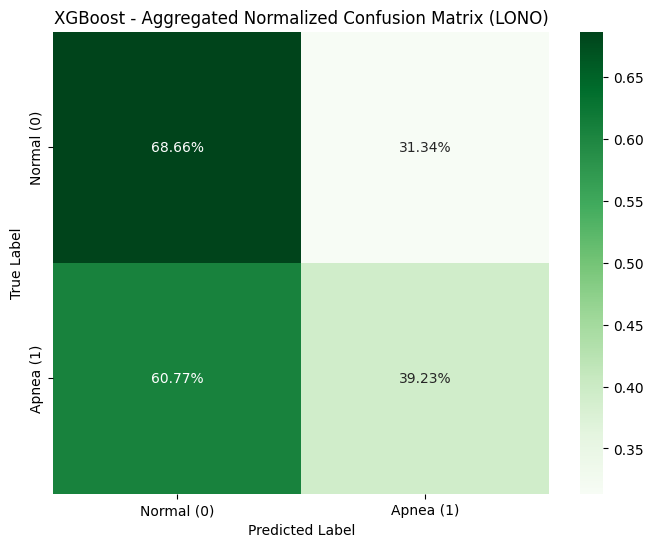

In [7]:
# In the final cell (id: d9903739)
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Initialize lists to store results from all folds ---
all_fold_predictions = []
all_fold_true_labels = []

# --- 2. Setup Leave-One-Night-Out cross-validator ---
logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=groups)
print(f"Starting XGBoost Leave-One-Night-Out cross-validation with {n_folds} folds...")
print("----------------------------------------------------\\n")

# --- 3. Loop through each fold ---
for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    
    test_night = np.unique(groups[test_idx])[0]
    print(f"--- FOLD {fold + 1}/{n_folds} ---")
    print(f"Testing on Night: {test_night}\\n")

    # --- 4. Split the data for this fold ---
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- 5. FLATTEN THE DATA for XGBoost ---
    # Convert the 3D windowed data (samples, timesteps, features) to 2D
    n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
    X_train_flattened = X_train.reshape(-1, n_timesteps * n_features)
    X_test_flattened = X_test.reshape(-1, n_timesteps * n_features)
    print(f"  - Data flattened for XGBoost. Train shape: {X_train_flattened.shape}")
    
    # --- 6. Balance the TRAINING data for this fold using SMOTE ---
    print(f"  - Original training distribution: {Counter(y_train)}")
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train)
    print(f"  - Resampled training distribution: {Counter(y_train_resampled)}")

    # # pos_weight = Counter(y_train)[0] / Counter(y_train)[1]
    # print(f"  - Calculated scale_pos_weight: {pos_weight:.2f}")

    # --- 7. Initialize and Train a NEW XGBoost model for this fold ---
    print("  - Training XGBoost model...")
    # It's crucial to re-initialize the model for each fold.
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        # scale_pos_weight=pos_weight,
        n_estimators=300,         # Number of trees (can be tuned)
        learning_rate=0.001,
        max_depth=5,              # Max depth of a tree (can be tuned)
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        n_jobs=-1                 # Use all available CPU cores for faster training
    )
    
    # Train the model on the balanced data
    model.fit(X_train_resampled, y_train_resampled)
    print(f"  - Training complete.")
            
    # --- 8. Evaluate the fold and store results ---
    fold_preds = model.predict(X_test_flattened)
    
    all_fold_predictions.extend(fold_preds)
    all_fold_true_labels.extend(y_test)
    print(f"  - Evaluation complete for fold {fold + 1}.\\n")


# --- FINAL AGGREGATED EVALUATION (after all folds are complete) ---
print("\\n====================================================")
print("XGBoost Leave-One-Night-Out Cross-Validation Complete.")
print("Aggregated Results Across All Folds:")
print("====================================================")

# --- Final Classification Report ---
print('\\nAggregated Classification Report')
print('------------------------------')
class_names = ['Normal (0)', 'Apnea (1)']
print(classification_report(all_fold_true_labels, all_fold_predictions, target_names=class_names))

# --- Final Confusion Matrix ---
print('Aggregated Confusion Matrix')
print('---------------------------')
cm = confusion_matrix(all_fold_true_labels, all_fold_predictions)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.2%', cmap='Greens', # Different color for clarity
    xticklabels=class_names, yticklabels=class_names
)
plt.title('XGBoost - Aggregated Normalized Confusion Matrix (LONO)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Starting LONO CV with 9 folds...

FOLD 1/9 - Testing on: 04-04-2025
  Original distribution: Counter({np.int64(0): 24608, np.int64(1): 709})
  Fold 1 complete.

FOLD 2/9 - Testing on: 05-04-2025
  Original distribution: Counter({np.int64(0): 24997, np.int64(1): 607})
  Fold 2 complete.

FOLD 3/9 - Testing on: 08-05-2025
  Original distribution: Counter({np.int64(0): 24618, np.int64(1): 845})
  Fold 3 complete.

FOLD 4/9 - Testing on: 10-05-2025
  Original distribution: Counter({np.int64(0): 27291, np.int64(1): 910})
  Fold 4 complete.

FOLD 5/9 - Testing on: 11-05-2025
  Original distribution: Counter({np.int64(0): 24303, np.int64(1): 798})
  Fold 5 complete.

FOLD 6/9 - Testing on: 16-04-2025
  Original distribution: Counter({np.int64(0): 24370, np.int64(1): 819})
  Fold 6 complete.

FOLD 7/9 - Testing on: 24-04-2025
  Original distribution: Counter({np.int64(0): 24378, np.int64(1): 858})
  Fold 7 complete.

FOLD 8/9 - Testing on: 25-04-2025
  Original distribution: Counter({np.int64(

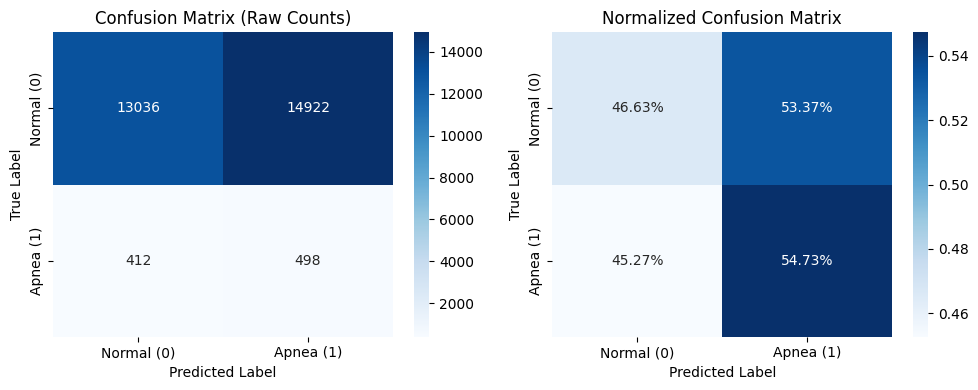

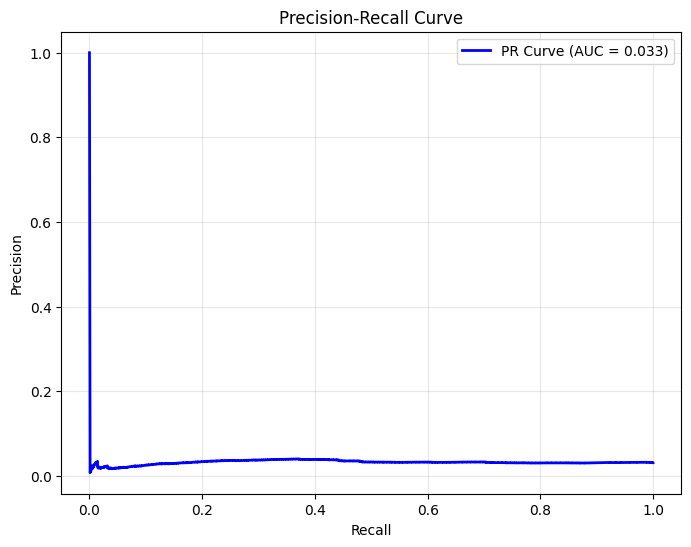

In [18]:
# Improved XGBoost implementation with better SMOTE handling

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

class ImprovedXGBoostSMOTE:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.results = []
        
    def compare_resampling_methods(self, X_train_flat, y_train):
        """Compare different resampling strategies"""
        methods = {
            'SMOTE': SMOTE(random_state=self.random_state),
            'ADASYN': ADASYN(random_state=self.random_state),
            'BorderlineSMOTE': BorderlineSMOTE(random_state=self.random_state),
            'No_Resampling': None
        }
        
        results = {}
        for name, method in methods.items():
            if method is None:
                # Use scale_pos_weight instead
                pos_weight = Counter(y_train)[0] / Counter(y_train)[1]
                X_resampled, y_resampled = X_train_flat, y_train
                model_params = {'scale_pos_weight': pos_weight}
            else:
                X_resampled, y_resampled = method.fit_resample(X_train_flat, y_train)
                model_params = {}
            
            results[name] = {
                'X_resampled': X_resampled,
                'y_resampled': y_resampled,
                'model_params': model_params,
                'distribution': Counter(y_resampled)
            }
        
        return results
    
    def create_pipeline_with_pca(self, n_components=100, resampling_method='ADASYN'):
        """Create a pipeline with PCA and resampling"""
        
        if resampling_method == 'SMOTE':
            resampler = SMOTE(random_state=self.random_state)
        elif resampling_method == 'ADASYN':
            resampler = ADASYN(random_state=self.random_state)
        elif resampling_method == 'BorderlineSMOTE':
            resampler = BorderlineSMOTE(random_state=self.random_state)
        else:
            resampler = None
            
        if resampler:
            pipeline = ImbPipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_components)),
                ('resampler', resampler),
                ('classifier', xgb.XGBClassifier(
                    objective='binary:logistic',
                    n_estimators=300,
                    learning_rate=0.01,
                    max_depth=6,
                    eval_metric='logloss',
                    random_state=self.random_state,
                    n_jobs=-1
                ))
            ])
        else:
            # No resampling, use scale_pos_weight
            pipeline = ImbPipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_components)),
                ('classifier', xgb.XGBClassifier(
                    objective='binary:logistic',
                    scale_pos_weight=10,  # Will be updated dynamically
                    n_estimators=300,
                    learning_rate=0.01,
                    max_depth=6,
                    eval_metric='logloss',
                    random_state=self.random_state,
                    n_jobs=-1
                ))
            ])
        
        return pipeline
    
    def run_cross_validation(self, X, y, groups, use_pca=True, n_components=100):
        """Run leave-one-night-out cross-validation"""
        
        logo = LeaveOneGroupOut()
        n_folds = logo.get_n_splits(groups=groups)
        
        all_predictions = []
        all_true_labels = []
        all_probabilities = []
        
        print(f"Starting LONO CV with {n_folds} folds...")
        print("=" * 50)
        
        for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
            test_night = np.unique(groups[test_idx])[0]
            print(f"\nFOLD {fold + 1}/{n_folds} - Testing on: {test_night}")
            
            # Split data
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Flatten for XGBoost
            n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
            X_train_flat = X_train.reshape(-1, n_timesteps * n_features)
            X_test_flat = X_test.reshape(-1, n_timesteps * n_features)
            
            print(f"  Original distribution: {Counter(y_train)}")
            
            if use_pca:
                # Use pipeline with PCA
                pipeline = self.create_pipeline_with_pca(n_components, 'SMOTE')
                
                # Update scale_pos_weight if not using resampling
                if hasattr(pipeline.named_steps['classifier'], 'scale_pos_weight'):
                    pos_weight = Counter(y_train)[0] / Counter(y_train)[1]
                    pipeline.named_steps['classifier'].scale_pos_weight = pos_weight
                
                pipeline.fit(X_train_flat, y_train)
                fold_preds = pipeline.predict(X_test_flat)
                fold_probs = pipeline.predict_proba(X_test_flat)[:, 1]
                
            else:
                # Traditional approach without PCA
                smote = SMOTE(random_state=self.random_state)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
                
                print(f"  Resampled distribution: {Counter(y_train_resampled)}")
                
                model = xgb.XGBClassifier(
                    objective='binary:logistic',
                    n_estimators=300,
                    learning_rate=0.01,
                    max_depth=6,
                    eval_metric='logloss',
                    random_state=self.random_state,
                    n_jobs=-1
                )
                
                model.fit(X_train_resampled, y_train_resampled)
                fold_preds = model.predict(X_test_flat)
                fold_probs = model.predict_proba(X_test_flat)[:, 1]
            
            all_predictions.extend(fold_preds)
            all_true_labels.extend(y_test)
            all_probabilities.extend(fold_probs)
            
            print(f"  Fold {fold + 1} complete.")
        
        return all_true_labels, all_predictions, all_probabilities
    
    def evaluate_results(self, y_true, y_pred, y_prob):
        """Comprehensive evaluation of results"""
        
        print("\n" + "=" * 60)
        print("FINAL CROSS-VALIDATION RESULTS")
        print("=" * 60)
        
        # Classification report
        print("\nClassification Report:")
        print("-" * 40)
        class_names = ['Normal (0)', 'Apnea (1)']
        print(classification_report(y_true, y_pred, target_names=class_names))
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(10, 4))
        
        # Raw confusion matrix
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix (Raw Counts)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # Normalized confusion matrix
        plt.subplot(1, 2, 2)
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()
        
        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, 
                label=f'PR Curve (AUC = {pr_auc:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return {
            'classification_report': classification_report(y_true, y_pred, output_dict=True),
            'confusion_matrix': cm,
            'pr_auc': pr_auc
        }

# Usage example:

# Initialize the improved XGBoost with SMOTE
improved_model = ImprovedXGBoostSMOTE(random_state=42)

# Run cross-validation with PCA
y_true, y_pred, y_prob = improved_model.run_cross_validation(
    X, y, groups, use_pca=True, n_components=100
)

# Evaluate results
results = improved_model.evaluate_results(y_true, y_pred, y_prob)
